In [1]:
import magni
from magni.cs.reconstruction.amp import run, config
from magni.cs.reconstruction.amp.util import theta_mm
import magni.utils.matrices as mat

import numpy as np
from scipy.misc import imresize
import scipy.ndimage as scimg
import scipy.fftpack as spfft
import matplotlib.pyplot as plt
from skimage.measure import compare_psnr

np.random.seed(1234)
np.set_printoptions(precision=3)
%matplotlib inline

%load_ext line_profiler

# GET SIGNAL DATA
[DCT](http://bugra.github.io/work/notes/2014-07-12/discre-fourier-cosine-transform-dft-dct-image-compression/)


In [7]:


def dct2(x):
        return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

""" Objective here is to see how k-sparse is the image? """
def study_dct_k(url_img, nx=100, ny = 100, psnr_threshold = 25, show = False):
    img = scimg.imread(url_img, flatten=True, mode='L')
    img_resize = imresize(img, (nx,ny))/255.0
    alpha = dct2(img_resize)
    
    alpha_hist = np.sort(np.abs(alpha.ravel()))
    range_study = range(50,100,5)
    if show : f, axarr = plt.subplots(len(range_study), 1, figsize=(17,17))

    for i, perc_i in enumerate(range_study):
        alpha_10x_percentile_val = np.percentile(alpha_hist, perc_i)
        alpha_plt = alpha.copy()
        alpha_plt[(alpha_plt > -1*alpha_10x_percentile_val) & (alpha_plt < alpha_10x_percentile_val)] = 0
        k_sparse = len(np.nonzero(alpha_plt)[0])
        alpha_plt_idct2 = idct2(alpha_plt)
        if show : axarr[i].imshow(alpha_plt_idct2, cmap='gray')
        psnr = compare_psnr((img_resize).astype('float32'), alpha_plt_idct2.astype('float32'))
        if show : print (perc_i, 'th percentile:', alpha_10x_percentile_val, ' PSNR:', psnr, 'dB', ' ', k_sparse, '-sparse')
        
        if psnr >= psnr_threshold:
            k_sparse_res = k_sparse
    
    if show : print ('\nThreshold pSNR = ', psnr_threshold)
    if show : print ('N = ', nx*ny)
    if show : print ('k-sparse:', k_sparse_res)
    if show : print ('m = O(k*log(N)) ~ ', k_sparse_res * np.log(nx*ny))
    return k_sparse_res
        

def get_data_basic():
    k, m, N = 10, 200, 400
    A = 1 / np.sqrt(m) * np.random.randn(m, N)
    alpha = np.zeros((N, 1))
    alpha[:k] = np.random.normal(scale=1, size=(k, 1))
    y = A.dot(alpha)
    # print ('Alpha:', alpha)
    # print ('y:', y)
    print ('Variable Shapes:', y.shape, A.shape, alpha.shape)
    return y, A, alpha, m, N

""" 
Notes
 - unable to create random A matrices for images above 100 x 100
 - need to find an in memory option
"""
def get_data_img(url_img, show = False, nx = 100, ny = 100):
    img = scimg.imread(url_img, flatten=True, mode='L')/255.0
    img_resize = imresize(img, (nx,ny))
    alpha = dct2(img_resize)
    if show : 
        f1, axarr1 = plt.subplots(1,2, figsize=(10,10))
        axarr1[0].imshow(img, cmap=plt.cm.gray)
        axarr1[1].imshow(img_resize, cmap=plt.cm.gray)
        
        f2, axarr2 = plt.subplots(1,2, figsize=(10,10))
        # axarr2[2].imshow(alpha, cmap=plt.cm.gray)
        # axarr2[2].imshow(alpha[:50, :50],cmap=plt.cm.Paired)
        axarr2[0].imshow(alpha,cmap=plt.cm.Paired)
        axarr2[1].hist(np.log10(np.abs(alpha.ravel())), bins=100, color='#348ABD', alpha=.3, histtype='stepfilled')
    
    print ('Img shape:', img.shape, ' Resized:', img_resize.shape)
    MR = 0.6
    N = alpha.shape[1] * alpha.shape[0]
    m = int(N * MR)
    # k = int(study_dct_k(url_img, show=1))
    
    """
    A as a matrix of iid variables drawn from Gaussian or bernoulli distributions is inherently inchoherent with 
        all other sparsifying basis
    """
    # A = 1 / np.sqrt(400) * np.random.randn(m, N)
    # A = np.random.randn(m, N)
    # A = np.random.choice([0,1], size=(k,N))
    A = np.empty((m, N), dtype=np.float16)
    A_size_mb = A.nbytes/1024.0/1024.0
    print ('A (MB):', A_size_mb, ' A.shape:', A.shape)
    if A_size_mb < 2000:
        for i in range(m):
            A[i] = np.random.randn(1,N)[0]
        for j in range(A.shape[1]):
            A[:,j] = A[:,j]/np.sqrt(np.sum(np.abs(A[:,j]**2)))
        

        alpha = alpha.reshape((N,1))
        alpha = alpha/np.amax(alpha)
        
        # measurement_style = 'random'
        measurement_style = 'linear'
        if measurement_style == 'random':
            rand_idxs = np.random.choice([0,1], size = m)
            y = alpha[rand_idxs]
        else:
            y = A.dot(alpha)
        
        if show:
            pass
            # print ('Alpha:', alpha)
            # print ('y:', y)
        print ('Variable Shapes:', y.shape, A.shape, alpha.shape)
        return y, A, alpha, m, N
    else:
        print ('MemoryError: For variable A')
        return [], [], [], 0, 0

def get_data_img_v2(url_img, show=False):
    # https://stats.stackexchange.com/questions/62416/image-reconstruction-using-compressed-sensing
    nx, ny = 100, 100
    N = nx*ny
    MR = 0.5
    k = int(N*MR)
    k = 4900
    
    img = scimg.imread(url_img, flatten=True, mode='L')
    img_resize = imresize(img, (nx,ny))/255

    Atemp = np.zeros((1, N))
    idxs = np.random.permutation(np.arange(1, N))
    rand_idxs = sorted(idxs[1:k+1])
    
    A = np.zeros((k, N))
    for i, idx in enumerate(rand_idxs):
        Atemp[0,idx] = 1
        A[i, :] = spfft.dct(Atemp)
        Atemp[0, idx] = 0
    
    alpha = img_resize.reshape(N,1)
    y = alpha[rand_idxs]
    
    if show:
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(img, cmap = plt.cm.gray)
        axarr[1].imshow(img_resize, cmap = plt.cm.gray)
        axarr[2].imshow(y.reshape((70,70)), cmap = plt.cm.gray)
    
    print ('Variable Shapes:', y.shape, A.shape, alpha.shape)
    return y, A, alpha

""" DCT STUDY """
# url_img = '../noniterative/data/original/SRCNN/Test/Set14/baboon.bmp'
# k = study_dct_k(url_img, show=0)

""" CS STUDY """
basic = 0
if basic:
    y, A, alpha, m, N = get_data_basic()
    # print (list(alpha))
else:
    url_img = '../noniterative/data/original/SRCNN/Test/Set14/baboon.bmp'
    
    nx = ny = 100
    y, A, alpha, m, N = get_data_img(url_img, show=0, nx = nx, ny = ny)
    # %lprun -f get_data_img get_data_img(url_img, show=0)
    
    # y, A, alpha = get_data_img_v2(url_img, show=1)
    # print (y)

Img shape: (480, 500)  Resized: (100, 100)
A (MB): 114.44091796875  A.shape: (6000, 10000)
Variable Shapes: (6000, 1) (6000, 10000) (10000, 1)


# SAMPLE FROM DOCS
[LINK](http://magni.readthedocs.io/en/latest/magni.cs.reconstruction.amp._algorithm.html)

----------------- CONFIG VALUES -------------------------
dict_keys(['alpha_bar', 'tolerance', 'convert', 'threshold', 'stop_criterion', 'threshold_parameters', 'stop_criterion_name', 'AH', 'history', 'AH_dot_chi', 'true_solution', 'report_history', 'delta', 'iterations', 'chi'])
iterations: 300
Thresholding function: <magni.cs.reconstruction.amp.threshold_operator.SoftThreshold object at 0x7fd70e512b70>
Threshold parameters: {'threshold_level_update_method': 'residual', 'tau_hat_sq': 1.0, 'theta': 0.743}
Convert: <class 'numpy.float64'>
Stop criterion: <magni.cs.reconstruction.amp.stop_criterion.MSEConvergence object at 0x7fd70e512d68>
Tolerance: 1e-06
----------------- CONFIG VALUES -------------------------
Iter: 0 / 300
Error: 6.34707863539e-06
Error: 9.15043137521e-05
Error: 3.99753939765e-05
Error: 1.78811251301e-05
Error: 8.93700947967e-06
Error: 5.030726452e-06
Error: 2.88650514767e-06
Error: 1.77452438661e-06
Error: 1.23600462188e-06
Error: 9.47275286712e-07
Total Iterations: 

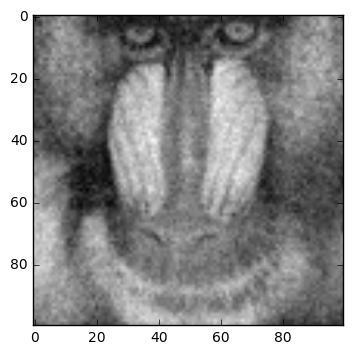

In [8]:
config['threshold_parameters'] = {'threshold_level_update_method': 'residual',
                                    'theta': theta_mm(float(m) / N)   #regularization param for thresholding func
                                  , 'tau_hat_sq': 1.0
                                 }
config['report_history'] = True
alpha_hat, history = run(y, A)
residual = np.abs(alpha - alpha_hat) > 1e-2
residual = np.abs(alpha - alpha_hat)
residual_max = residual.max()

print ('\n -------------------------------------------------- ')
#print ('Residual:', residual, ' Max residual:',residual_max ,' SUM:', np.sum(residual))
# print ('alpha_hat:', alpha_hat)
# print ('alpha:', alpha)
print (' Max residual:',residual_max ,' SUM:', np.sum(residual))
print (' pSNR:', compare_psnr(alpha.astype('float32'), alpha_hat.astype('float32')))
print ('alpha_hat:', alpha_hat.shape)

if basic == 0:
    alpha_hat = idct2(alpha_hat.reshape((nx, ny)))
    plt.imshow(alpha_hat, cmap = plt.cm.gray)

# EXPERIMENTATION

In [4]:
# y=zeros(m,1);
#     remaining_columns=n;
#     K=4096;%How large each submatrtix is.  Determines memory usage
#     iters=ceil(n/K);
#     for i=0:iters-1
#         rng(i);
#         col_num=min(K,remaining_columns);
#         phi_columns=randn(m,col_num);
#         column_norms=sqrt(sum(abs(phi_columns).^2,1));
#         phi_columns=bsxfun(@rdivide,phi_columns,column_norms);
#         y=y+phi_columns*x(K*i+1:K*i+col_num);
#         remaining_columns=remaining_columns-K;
#     end
# end

N = 100 * 100
m = 5000
y = np.zeros(m,1)
K = 4096 #size of submatrix
iters = np.ceil(N/K)

remaining_columns = N
for i in range(iters):
    np.random.seed(i)
    col_num = min(K, remaining_columns)
    phi_columns = np.random.randn(m, col_num)

TypeError: data type not understood

In [ ]:
len(np.nonzero(np.array([1,2,3,4,0,0,0]))[0])